In [1]:
%autosave 45

Autosaving every 45 seconds


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import json
import k3d
from plyfile import PlyData, PlyElement

### How is data in "coordinates" related to images in "real_images" or "matterport_poses"?
In coordinates there are 340 images, in real_images there are 74

It seems like 74 images are those which were taken with the Matterport device. 340 images are rendered point clouds from those 74. I just have to now figure oout how to produce actuall images from those .npz files. (also how to vary FoV)

In [3]:
!ls /data/cornucopia/ib255/shared_file_system/derivative_datasets/scene_coordinate_regression/mt_style/DATA/cued_jason/ds_combined_240/ 
#DS_004_CUED_canteen/coordinates  

class_ids.json	ids_labels   images  meta2
colors.lst	ids_table.p  labels  meta.json


class_ids.json, meta.json, colors.lst - don't contain anything interesting atm

ids_table.p - i can't open yet. Not sure how to open .p file

# Explore rendered images

In [4]:
# !ls /data/cornucopia/ib255/shared_file_system/derivative_datasets/scene_coordinate_regression/mt_style/DATA/cued_jason/ds_combined_240/images  

It seems like images/ ids_labels/ labels/ all have the samedata in them. 

(240, 480, 3)


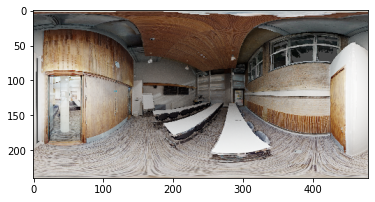

In [5]:
global_dir = "/data/cornucopia/ib255/shared_file_system/derivative_datasets/scene_coordinate_regression/mt_style/DATA/cued_jason/ds_combined_240/"

images_dir = "images/"
img = mpimg.imread(global_dir + images_dir + "DS_000_JDG_19_Teaching_Room_Manual_Pose_240p_0001_rendered.png")
print(img.shape)
plt.imshow(img)

## .npz

In [6]:
npz_dir = "meta2/"
npz_data = np.load(global_dir + npz_dir + "DS_000_JDG_19_Teaching_Room_Manual_Pose_240p_0001_rendered.npz")
print(npz_data['points_3d_world'].shape)

(240, 480, 3)


In [19]:
npz_data.files

['R', 'T', 'points_3d_world', 'points_3d_camera', 'points_3d_sphere', 'mask']

shape of **npz** is the same as that of **img**

question is should i regress world coordinates or camera coordinates?

In [114]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=npz_data['points_3d_world'], point_size=0.2)
plot += plt_points
plt_points.shader='3d'
plot.display()

Output()

In [15]:
def get_indices(width,height):
    N = (height-1)*(width-1)
    indices = np.zeros((2*N,3))
#     indices[0] = [0,w,w+1]
#     indices[N] = [0,1,w+1]
#     indices[1] = [1,w+1,w+2]
#     indices[N+1] = [1,2,w+2]
#     indices[1] = [1,w+1,]

    for h in range(height-1):
        for w in range(width-1):
            indices[(width-1)*h + w] = [width*h + w, width*(h+1) + w,  width*(h+1) + w +1]
            indices[N + (width-1)*h + w] = [width*h + w, width*h + w + 1,  width*(h+1) + w +1]
    
    return indices

In [14]:
height, width = 480,240
N = (height-1)*(width-1)
N + (width-1)*(height-2)+width-2

228961

In [16]:
indices = get_indices(240,480)
points_camera = npz_data['points_3d_world'].reshape(-1, npz_data['points_3d_world'].shape[-1])

In [17]:
plot = k3d.plot(name='mesh')
plt_mesh = k3d.mesh(points_camera, indices)
plot += plt_mesh
plot.display()

/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float16" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

# Explore directory

### coordinates

There are 741 files. 740 rendered images (340 .npz files) and (340 .ply files) per image. One file all_world.ply

.ply - polygon file format used to store 3D objects obtained with 3D scanners. 

In [3]:
# !ls /data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates

In [20]:
coord_data_dir = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates/"
coord_npz = "0036_rendered.png_config.npz"
coord_ply = "0038_rendered.png_config_world.ply"
# 0036_rendered.png_config.npz
# 0038_rendered.png_config_world.ply
npz_data = np.load(coord_data_dir + coord_npz)

In [21]:
npz_data.files

['R_blender',
 'points_3d_world',
 'points_3d_camera',
 'points_3d_sphere',
 'mask',
 'image_colors',
 'T_blender']

## points_3d_world & points_3d_camera

In [22]:
p_3d_world = npz_data['points_3d_world']
p_3d_camera = npz_data["points_3d_camera"]

In [23]:
points_camera = p_3d_camera.reshape(-1, p_3d_camera.shape[-1])
points_world = p_3d_world.reshape(-1, p_3d_world.shape[-1])

In [8]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=points_camera[::100], point_size=0.2, color = 0xff0000)
plot += plt_points
plt_points = k3d.points(positions=points_world[::100], point_size=0.2, color = 0xffff00)
plot += plt_points

plt_points.shader='3d'
plot.display()

/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float16" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [10]:
p_3d_sphere = npz_data['points_3d_sphere']
R_blender = npz_data['R_blender']
mask = npz_data['mask']
image_colors = npz_data['image_colors']
T_blender = npz_data['T_blender']

## points_3d_sphere

In [18]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=p_3d_sphere[::100], point_size=0.2)
plot += plt_points

plt_points.shader='3d'
plot.display()

Output()

In [12]:
print("Rotation matrix")
print(R_blender)
print()
print("Translation matrix")
print(T_blender)

Rotation matrix
[[ 9.96401366e-01 -7.40998562e-09 -8.47603522e-02]
 [-8.47603522e-02 -8.71081775e-08 -9.96401366e-01]
 [-5.19007470e-18  1.00000000e+00 -8.74227801e-08]]

Translation matrix
[-0.02554654 14.55505753 -3.90014553]


## relate camer to world coordinates

in order to get world coordinates we need to do CAMERA = (WORLD - T) * R
or WORLD = CAMERA * R_inv + T

Rotation and Translation matrix will be different depeding ona camera pose. 
This might prove useful as we want to regress scene coordinates

In [37]:
points_world_trans = np.dot(points_world - T_blender, R_blender)

In [38]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=points_camera[::100], point_size=0.2, color = 0xff0000)
plot += plt_points
plt_points = k3d.points(positions=points_world_trans[::100], point_size=0.2, color = 0xffff00)
plot += plt_points

plt_points.shader='3d'
plot.display()

Output()

## mask
has binary values, in 99.8% 1's and some 0's
Not yet sure what it does

In [43]:
print(mask.shape)
print(np.max(mask))
print(np.min(mask))
print(np.mean(mask))

(2048, 4096, 1)
1
0
0.9985998868942261


## image_Colors
These are colorings for all the points in the point cloud above

In [24]:
image_colors = npz_data['image_colors']

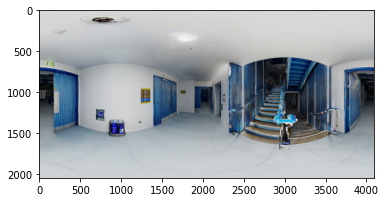

In [25]:
plt.imshow(image_colors)

In [46]:
image_colors.shape

(2048, 4096, 3)

In [59]:
image_colors[0]

array([[216, 215, 215],
       [215, 215, 215],
       [216, 215, 215],
       ...,
       [216, 216, 215],
       [216, 215, 215],
       [216, 215, 215]], dtype=uint8)

# PLY file
Seems like we have 6 elements for each datapoint 3D position and 3D color.

Why 524288 ? what resolutionis it? 500x1000?

In [51]:
plydata = PlyData.read(coord_data_dir + coord_ply)

In [58]:
print("Num of points: ", len(plydata['vertex']))
print("Sample point: ", plydata['vertex'][0])

Num of points:  524288
Sample point:  (0.194744, 14.853905, -2.762443, 209, 211, 212)


"all_world.ply" fiel has 20 mln data points, maybe that's the final file we use for image rendering.

In [71]:
all_world_ply = PlyData.read(coord_data_dir + "all_world.ply")

In [72]:
print("Num of points: ", len(all_world_ply['vertex']))

Num of points:  19398730


### matterpak_data


has some jpgs & pdfs:
* ceiling colorplan - a 2D map of ceiling
* color plan - 2D bird eye view of a flor map
* <some_ID>_num.jpg - some renders of walls


and also other files:
* cloud.xyz
* .obj & .mtl
* .blend objects

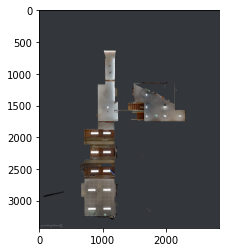

In [58]:
dir_matterpak_data = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/matterpak_data/"

img = mpimg.imread(dir_matterpak_data + "ceilingcolorplan_000.jpg")
imgplot = plt.imshow(img)
plt.show()

In [59]:
# !ls /data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/matterpak_data

### matterport_poses.json

In [44]:
file_name = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/matterport_poses.json"

with open(file_name) as f:
    matterport_poses = json.load(f)

print("Number of posses:  ", len(matterport_poses))
print("Each pose has following data: ", list(matterport_poses[0].keys()))
print("CAMERA MODE: all poses have this set to 1")
print("CAMERA POSITION: 3D coordinates ..not sure.. maybe the world coordinates of the camera center.")
print("CAMERA QUARTERNION: 4D coordinates ..not sure.. 1st and 2nd coordiante are 0")
print("SCAN ID: some id, potentially to other data. i.e. ef52aa66292e493cb2b721c3ff610c14")


Number of posses:   74
Each pose has following data:  ['camera_mode', 'camera_position', 'camera_quaternion', 'scan_id']
CAMERA MODE: all poses have this set to 1
CAMERA POSITION: 3D coordinates ..not sure.. maybe the world coordinates of the camera center.
CAMERA QUARTERNION: 4D coordinates ..not sure.. 1st and 2nd coordiante are 0
SCAN ID: some id, potentially to other data. i.e. ef52aa66292e493cb2b721c3ff610c14


### real_images

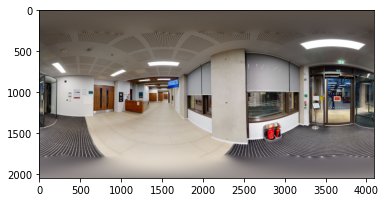

In [18]:
image_sample = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/real_images/The-James-Dyson-Building-07102020_053313.jpg"

img = mpimg.imread(image_sample)
imgplot = plt.imshow(img)
plt.show()

there is one image per MatterPort pose (so 74 images). matterport_poses.json file has more data associated with each of those images.

In [22]:
!ls /data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/real_images | wc -l

74


coordinates  matterpak_data  matterport_poses.json  real_images
